### Task 2. ICP (4pt)

In this task, you are required to align two point clouds (source and target) using the Iterative Closest Point (ICP) algorithm discussed in class. The task consists of two parts.

#### a) (2pt)

In part 1, you have to load the demo point clouds provided by Open3D and align them using ICP. **Caution**: These point clouds are different from the point cloud used in the previous question. You are expected to write a custom function to implement the ICP algorithm. 

Use the following code snippet to load the demo point clouds and to visualize the registration results. You will need to pass the final 4X4 homogeneous transformation (pose) matrix obtained after the ICP refinement. Explain in detail the process you followed to perform the ICP refinement.



<div style="border: None; padding: 10px; background-color: 	#2F3F4F;">

```python
import open3d as o3d
import copy

demo_icp_pcds = o3d.data.DemoICPPointClouds()
source = o3d.io.read_point_cloud(demo_icp_pcds.paths[0])
target = o3d.io.read_point_cloud(demo_icp_pcds.paths[1])

# Write your code here

def draw_registration_result(source, target, transformation):
    """
    param: source - source point cloud
    param: target - target point cloud
    param: transformation - 4 X 4 homogeneous transformation matrix
    """
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4459,
                                      front=[0.9288, -0.2951, -0.2242],
                                      lookat=[1.6784, 2.0612, 1.4451],
                                      up=[-0.3402, -0.9189, -0.1996])


In [60]:
# Import Necessary Libraries
import open3d as o3d
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [52]:
# Loading data
demo_icp_pcds = o3d.data.DemoICPPointClouds()
source = o3d.io.read_point_cloud(demo_icp_pcds.paths[0])
target = o3d.io.read_point_cloud(demo_icp_pcds.paths[1])

In [53]:
# No. of tests
N=100
# Initial transformation matrix (4x4 homogeneous)
trans_init = np.asarray([
    [0.862,  0.011, -0.507,  0.5],
    [-0.139, 0.967, -0.215,  0.7],
    [0.487,  0.255,  0.835, -1.4],
    [0.0,    0.0,    0.0,    1.0]
])

# Apply the initial transformation to the source point cloud
source = source.transform(trans_init)

In [54]:
# Convert Open3D point clouds to NumPy arrays for processing
my_target = np.asarray(target.points)
my_source = np.asarray(source.points[:my_target.shape[0]])

In [55]:
def best_fit_transform(A, B):
    """
    Calculates the least-squares best-fit transform that maps points A to B.
    Returns the homogeneous transformation matrix, rotation matrix, and translation vector.
    """
    
    scalar = A.shape[1]
    A = A.T
    B = B.T 
    centroid_A = (np.mean(A, axis=1)).reshape(-1, 1)
    centroid_B = (np.mean(B, axis=1)).reshape(-1, 1)
    
    A_centered = A - centroid_A
    B_centered = B - centroid_B

    H = A_centered @ B_centered.T
    U, _ , Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    t = centroid_B - R @ centroid_A

    # Homogeneous transformation
    T = np.identity(scalar + 1)
    T[:scalar, :scalar] = R
    T[:scalar, scalar] = t.T

    return T, R, t

In [56]:
def nearest_neighbor(src, dst_kdtree):
    """
    Finds the nearest (Euclidean) neighbor in dst for each point in src using Open3D's KDTree.
    Returns distances and indices of the nearest neighbors.
    """
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst_kdtree)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()

In [ ]:
def icp(A, B, init_pose=None, max_iterations=20, tolerance=1e-4):
    """
    Performs the Iterative Closest Point algorithm to align point cloud A to point cloud B.
    Returns the final transformation matrix, distances, and number of iterations.
    """
    assert A.shape == B.shape
    m = A.shape[1]
    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1, A.shape[0]))
    dst = np.ones((m+1, B.shape[0]))
    src[:m, :] = np.copy(A.T)
    dst[:m, :] = np.copy(B.T)
    
   
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    for i in range(max_iterations):
        
        distances, indices = nearest_neighbor(src[:m, :].T, dst[:m, :].T)
        T, _, _ = best_fit_transform(src[:m, :].T, dst[:m, indices].T)
        src = np.dot(T, src)  # update the current source
        mean_error = np.mean(distances) # check error
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error
    T, _, _ = best_fit_transform(A, src[:m, :].T)  # calculating final transformation

    return T, distances, i

In [ ]:
def perform_icp( num_tests=100):
    """
    Performs ICP multiple times and returns the best transformation.
    """
    A = my_source
    for i in range(num_tests):
        B = my_target        
        best_T= icp(B, A, tolerance=0.1)[0]
    print(best_T)
    return best_T

In [ ]:
def draw_registration_result(source, target, transformation):
    """
    Visualizes the aligned source and target point clouds.
    """
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])      # Orange
    target_temp.paint_uniform_color([0, 0.651, 0.929]) # Blue
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries(
        [source_temp, target_temp],
        zoom=0.4459,
        front=[0.9288, -0.2951, -0.2242],
        lookat=[1.6784, 2.0612, 1.4451],
        up=[-0.3402, -0.9189, -0.1996]
    )

In [57]:
# Perform ICP
transformation = perform_icp()

# Visualize the result
draw_registration_result(source, target, transformation)


[[ 0.99999092 -0.00188073 -0.003824   -0.00243311]
 [ 0.00198401  0.99962844  0.02718542 -0.09554388]
 [ 0.00377145 -0.02719276  0.99962309  0.05347158]
 [ 0.          0.          0.          1.        ]]


Visualization saved as aligned_result_T2a.png


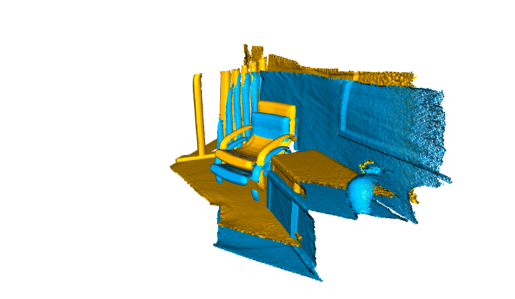

In [64]:
def save_visualization(source, target, transformation, save_path="aligned_result.png"):
    """
    Saves a visualization of the aligned source and target point clouds.
    
    Args:
        source (o3d.geometry.PointCloud): Source point cloud.
        target (o3d.geometry.PointCloud): Target point cloud.
        transformation (np.ndarray): 4x4 transformation matrix aligning source to target.
        save_path (str): Path to save the visualization image.
    """
    # Deepcopy to avoid modifying original point clouds
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    
    # Apply colors for distinction
    source_temp.paint_uniform_color([1, 0.706, 0])      # Orange for source
    target_temp.paint_uniform_color([0, 0.651, 0.929]) # Blue for target
    
    # Transform the source point cloud
    source_temp.transform(transformation)
    
    # Initialize the visualizer
    vis = o3d.visualization.Visualizer()
    vis.create_window(visible=False)  # Run visualization in the background
    
    # Add geometries
    vis.add_geometry(source_temp)
    vis.add_geometry(target_temp)
    
    # Configure view parameters for a better result
    ctr = vis.get_view_control()
    ctr.set_zoom(0.4459)
    ctr.set_front([0.9288, -0.2951, -0.2242])
    ctr.set_lookat([1.6784, 2.0612, 1.4451])
    ctr.set_up([-0.3402, -0.9189, -0.1996])
    
    # Capture the screen
    vis.poll_events()
    vis.update_renderer()
    vis.capture_screen_image(save_path)
    vis.destroy_window()
    print(f"Visualization saved as {save_path}")
    
# Save and display the visualization
save_path = "aligned_result_T2a.png"
save_visualization(source, target, transformation, save_path)

# Display the saved image
img = plt.imread(save_path)
plt.imshow(img)
plt.axis("off")  # Turn off axes for a clean image
plt.show()
